# 人力资源调度问题

## 目标和先决条件

在这个示例中，您将学习如何解决服务行业中一个关键的核心问题：人力资源调度。我们将演示如何使用数学优化来生成满足业务需求、最大化员工公平性和满意度，并最小化公司需要雇佣的临时工数量的最优人力资源调度方案。

这个建模示例属于高级水平，我们假设您了解Python和Gurobi Python API，并且您具有构建数学优化模型的高级知识。通常，这些示例的目标函数和/或约束条件比较复杂，或者需要使用Gurobi Python API的高级功能。

**下载仓库** <br />
您可以通过点击[这里](https://github.com/Gurobi/modeling-examples/archive/master.zip)下载包含此示例和其他示例的仓库。

## 动机
对于服务行业的公司来说，人是最重要的资产，也是最大的成本来源。
人力资源分配和人员调度处理的是工作安排和人员轮班分配，以满足随时间变化的资源需求。

这些问题对于依赖人力资源的服务行业公司非常重要，例如：
- 电话接线员
- 医院护士
- 警察
- 运输人员（飞机机组人员、公交车司机等）
- 酒店服务人员
- 餐厅服务人员

## 问题描述

考虑一个服务型企业，例如餐厅，它为未来两周（考虑一周7天）制定人力资源计划。该服务只需要一组技能。有多名拥有相同技能和相同生产力的雇佣工人，他们在两周规划期内的某些天可以工作。每个工作日只有一个班次。每个工作日的班次可能有不同的资源（工人）需求。服务企业可以从中介机构雇佣额外（临时）工人以满足班次需求。服务企业希望最小化需要雇佣的额外工人数量，作为次要目标，它希望平衡雇佣工人的工作量以确保公平性。

## 模型构建
数学规划是一种声明式方法，其中建模者制定一个能够捕捉复杂决策问题关键特征的数学优化问题。Gurobi优化器使用最先进的数学和计算机科学方法来解决数学优化问题。

数学优化模型有五个组成部分：
- 集合
- 参数
- 决策变量
- 约束条件
- 目标函数

### 集合和索引

$s \in \text{shifts}$：索引和班次集合。

$w \in workers$：索引和雇佣工人集合。

$availability= \{(w,s): w \in workers \; \text{可以工作于} \; s \in \text{shifts} \}$：该集合确定雇佣工人 $w$ 可以在班次 $s$ 工作。

### 参数

$\text{shiftRequirements}(s) \in \mathbb{N}$：此参数表示每个班次 $s \in \text{shifts}$ 所需的工人数量。

$pay(w) \in \mathbb{R^{+}}$：此参数是每个工人 $w \in workers$ 的每日工资。

$relTol$：此相对容差参数使得在解决次要目标的模型时，可以偏离主要目标函数的最优值。（见下文关于多目标优化过程的解释）。

### 计算参数
这些参数由输入参数和/或优化过程导出。

$Opt(totSlack)$：此参数是满足需求所需的额外工人的最小数量。

### 决策变量

$x(w,s) \in \{0,1\}$：如果工人 $w \in workers$ 被分配到班次 $s \in \text{shifts}$，则此变量等于1，否则为0。
此决策变量定义在 $availability$ 集合上。

$Slack(s) \geq 0$：此变量是满足班次 $s$ 需求所需的额外工人数量。

### 辅助变量
辅助变量由决策变量的值导出。

$totSlack$：此变量计算满足班次工人需求所需的额外工人总数。

$\text{totShifts}(w)$：此变量计算每个工人 $w \in workers$ 工作的班次总数。

$\text{minShift}$：此变量确定分配给工人的最小班次数。

$\text{maxShift}$：此变量确定分配给工人的最大班次数。

## 优化过程

在这个建模示例中，我们处理一个多目标模型，其主要目标是最小化满足班次需求所需的额外工人数量，次要目标是最小化任意两名工人之间工作班次数量的最大差异。这个次要目标平衡了分配给工人的工作量。
 
分层多目标优化方法首先用主要目标解决以下模型。

### 目标函数

- **主要目标：** 目标函数是最小化分配的额外工人数量。

\begin{equation}
\text{Min} \quad totSlack
\tag{0}
\end{equation}

### 约束条件

- **班次需求：** 所有班次需求必须得到满足。

\begin{equation}
\sum_{w \: \in \: workers} x(w,s)  +  Slack(s) = \text{shiftRequirements}(s) \quad \forall \; s \in \text{shifts}
\tag{1}
\end{equation}

- **临时工：** 计算所需的额外工人总数。

\begin{equation}
\sum_{s \: \in \: \text{shifts}} Slack(s) =  totSlack 
\tag{2}
\end{equation}

- **班次：** 计算每个工人的班次总数。

\begin{equation}
\sum_{s \: \in \: \text{shifts}} x(w,s)  = \text{totShifts}(w) \quad \forall \; w \in workers
\tag{3}
\end{equation}

- **二进制和非负约束：**

$$
x(w,s) \in \{0, 1 \}  \quad \forall \; (w,s) \in availability
$$

$$
Slack(s) \geq 0 \quad  \forall \; s \in \text{shifts}
$$

$$
\text{totShifts}(w) \geq 0 \quad \forall \; w \in workers
$$

$$
totSlack  \geq 0
$$

参数 $Opt(totSlack)$ 被设置为等于满足需求所需的额外工人的最小数量。即，$Opt(totSlack) = totSlack^{*} $，其中 $totSlack^{*} $ 是变量 $totSlack$ 的最优值。

对于给定的主要目标相对容差 $relTol$，我们现在解决以下模型，其中我们最小化次要目标。


### 目标函数

- **次要目标：** 目标函数是最小化分配给工人的最大班次数与最小班次数之间的差异。

\begin{equation}
\text{Min} \quad ( \text{maxShift} -  \text{minShift} )
\tag{4}
\end{equation}

### 约束条件

- **班次需求：** 所有班次需求必须得到满足。

\begin{equation}
\sum_{w \: \in \: workers} x(w,s)  +  Slack(s) = \text{shiftRequirements}(s) \quad \forall \; s \in \text{shifts}
\tag{1}
\end{equation}


- **相对容差：** 确保由主要目标最小化的额外工人总数（totSlack）在一定容差百分比内得到满足。

\begin{equation}
\sum_{s \: \in \: shifts} Slack(s) \leq (1+relTol)*Opt(totSlack)
\tag{5}
\end{equation}

- **班次：** 计算每个工人的班次总数。

\begin{equation}
\sum_{s \: \in \: \text{shifts}} x(w,s)  = \text{totShifts}(w) \quad \forall \; w \in workers
\tag{3}
\end{equation}

- **最小班次：** 计算分配给雇佣工人的最小班次数。

\begin{equation}
\text{minShift} = \text{Min} \{\text{totShifts}(w): \ w \; in \; workers \}  
\tag{6}
\end{equation}


- **最大班次：** 计算分配给雇佣工人的最大班次数。

\begin{equation}
\text{maxShift} = \text{Max} \{\text{totShifts}(w): \ w \; in \; workers \}
\tag{7}
\end{equation}

- **二进制和非负约束：**

$$
x(w,s) \in \{0, 1 \}  \quad \forall \; (w,s) \in availability
$$

$$
Slack(s) \geq 0 \quad  \forall \; s \in \text{shifts}
$$

$$
\text{totShifts}(w) \geq 0 \quad   \forall \; w \in workers
$$

$$
\text{maxShift},  \text{minShift}   \geq 0
$$

使用以下方法时，Gurobi Python API会自动完成此优化过程：

"Model.setObjectiveN()"

## Python实现

现在我们导入Gurobi Python模块。然后，我们使用给定数据初始化数据结构。

In [ ]:
%pip install gurobipy

In [ ]:
# 这个命令导入Gurobi函数和类。

import gurobipy as gp
from gurobipy import GRB


import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

## 输入数据

我们定义模型的所有输入数据。

### 参数

$\text{shiftRequirements}(s) \in \mathbb{N}$：此参数表示每个班次 $s \in \text{shifts}$ 所需的工人数量。

In [ ]:
# 每个班次所需的工人数量。
shifts, shiftRequirements = gp.multidict({
  "Mon1":  3,
  "Tue2":  2,
  "Wed3":  4,
  "Thu4":  4,
  "Fri5":  5,
  "Sat6":  6,
  "Sun7":  5,
  "Mon8":  2,
  "Tue9":  2,
  "Wed10": 3,
  "Thu11": 4,
  "Fri12": 6,
  "Sat13": 7,
  "Sun14": 5 })

### 参数

$pay(w) \in \mathbb{R^{+}}$：此参数是每个工人 $w \in workers$ 的每日工资。

In [ ]:
# 每个工人工作一个班次的薪资。
workers, pay = gp.multidict({
  "Amy":   10,
  "Bob":   12,
  "Cathy": 10,
  "Dan":   8,
  "Ed":    8,
  "Fred":  9,
  "Gu":    11 })

### 集合

$availability= \{(w,s): w \in workers \; \text{可以工作于} \; s \in \text{shifts} \}$：该集合确定雇佣工人 $w$ 可以在班次 $s$ 工作。



In [ ]:
# 工人可用性：定义每个雇佣工人在哪些天可以工作。

availability = gp.tuplelist([
('Amy', 'Tue2'), ('Amy', 'Wed3'), ('Amy', 'Fri5'), ('Amy', 'Sun7'),
('Amy', 'Tue9'), ('Amy', 'Wed10'), ('Amy', 'Thu11'), ('Amy', 'Fri12'),
('Amy', 'Sat13'), ('Amy', 'Sun14'), ('Bob', 'Mon1'), ('Bob', 'Tue2'),
('Bob', 'Fri5'), ('Bob', 'Sat6'), ('Bob', 'Mon8'), ('Bob', 'Thu11'),
('Bob', 'Sat13'), ('Cathy', 'Wed3'), ('Cathy', 'Thu4'), ('Cathy', 'Fri5'),
('Cathy', 'Sun7'), ('Cathy', 'Mon8'), ('Cathy', 'Tue9'), ('Cathy', 'Wed10'),
('Cathy', 'Thu11'), ('Cathy', 'Fri12'), ('Cathy', 'Sat13'),
('Cathy', 'Sun14'), ('Dan', 'Tue2'), ('Dan', 'Wed3'), ('Dan', 'Fri5'),
('Dan', 'Sat6'), ('Dan', 'Mon8'), ('Dan', 'Tue9'), ('Dan', 'Wed10'),
('Dan', 'Thu11'), ('Dan', 'Fri12'), ('Dan', 'Sat13'), ('Dan', 'Sun14'),
('Ed', 'Mon1'), ('Ed', 'Tue2'), ('Ed', 'Wed3'), ('Ed', 'Thu4'),
('Ed', 'Fri5'), ('Ed', 'Sun7'), ('Ed', 'Mon8'), ('Ed', 'Tue9'),
('Ed', 'Thu11'), ('Ed', 'Sat13'), ('Ed', 'Sun14'), ('Fred', 'Mon1'),
('Fred', 'Tue2'), ('Fred', 'Wed3'), ('Fred', 'Sat6'), ('Fred', 'Mon8'),
('Fred', 'Tue9'), ('Fred', 'Fri12'), ('Fred', 'Sat13'), ('Fred', 'Sun14'),
('Gu', 'Mon1'), ('Gu', 'Tue2'), ('Gu', 'Wed3'), ('Gu', 'Fri5'),
('Gu', 'Sat6'), ('Gu', 'Sun7'), ('Gu', 'Mon8'), ('Gu', 'Tue9'),
('Gu', 'Wed10'), ('Gu', 'Thu11'), ('Gu', 'Fri12'), ('Gu', 'Sat13'),
('Gu', 'Sun14')
])

## 模型部署

In [ ]:
# 创建初始模型。
m = gp.Model("workforce5")

Using license file c:\gurobi\gurobi.lic


### 决策变量

$x(w,s) \in \{0,1\}$：如果工人 $w \in workers$ 被分配到班次 $s \in \text{shifts}$，则此变量等于1，否则为0。
此决策变量定义在 $availability$ 集合上。

$Slack(s) \geq 0$：此变量是满足班次 $s$ 需求所需的额外工人数量。

In [ ]:
# 初始化分配决策变量。

x = m.addVars(availability, vtype=GRB.BINARY, name="x")

In [ ]:
# Slack决策变量确定满足每个班次需求所需的额外工人数量
slacks = m.addVars(shifts, name="Slack")

### 辅助变量
辅助变量由决策变量的值导出。

$totSlack$：此变量计算满足班次工人需求所需的额外工人总数。

$\text{totShifts}(w)$：此变量计算每个工人 $w \in workers$ 工作的班次总数。

$\text{minShift}$：此变量确定分配给工人的最小班次数。

$\text{maxShift}$：此变量确定分配给工人的最大班次数。

In [ ]:
# 辅助变量totSlack表示满足所有班次需求所需的额外工人总数。
totSlack = m.addVar(name='totSlack')

In [ ]:
# 辅助变量totShifts计算每个雇佣工人工作的总班次数
totShifts = m.addVars(workers, name="TotShifts")

### 约束条件

$$\sum_{w \: \in \: workers} x(w,s) \; + \; Slack(s) \; = \; \text{shiftRequirements}(s) \; \; \; \forall \; s \in shifts $$

In [ ]:
# 约束条件：所有班次需求必须得到满足。

shift_reqmts = m.addConstrs((x.sum('*',s) + slacks[s] == shiftRequirements[s] for s in shifts), name='shiftRequirement')


### 约束条件

$$ \sum_{s \: \in \: shifts} Slack(s) \; = \; totSlack  $$

In [ ]:
# 约束条件：设置辅助变量(totSlack)等于满足班次需求所需的额外工人总数
 
num_temps = m.addConstr(totSlack == slacks.sum(), name='totSlack')


### 约束条件

$$\sum_{s \: \in \: shifts} x(w,s) \; = \; \text{totShifts}(w) \; \; \forall \ w \; in \; workers$$

In [ ]:
# 约束条件：计算每个工人的总班次数

num_shifts = m.addConstrs((totShifts[w] == x.sum(w,'*') for w in workers), name='totShifts')


变量 $\text{minShift}$ 确定分配给工人的最小班次数。该变量计算如下：
$\text{minShift} = Min \{\text{totShifts}(w): \ w \; in \; workers \} $

变量 $\text{maxShift}$ 确定分配给工人的最大班次数。该变量计算如下：
$\text{maxShift} = Max \{\text{totShifts}(w): \ w \; in \; workers \} $

In [ ]:
# 辅助变量。 
# minShift是分配给工人的最小班次数 
# maxShift是分配给工人的最大班次数

minShift = m.addVar(name='minShift')

maxShift = m.addVar(name='maxShift')

# 约束条件： 
# 模型对象m的addGenConstrMin()方法添加一个新的通用约束，
# 确定一组变量中的最小值。 
# 第一个参数是变量，其值将等于其他变量的最小值，
# 在这种情况下是minShift。 
# 第二个参数是将取最小值的变量集，在这种情况下是(totShifts)。 
# 回想一下，totShifts变量定义在工人集合上，并确定雇佣工人将工作的班次数。
# 第三个参数是此约束的名称。

min_constr = m.addGenConstrMin(minShift, totShifts, name='minShift')

# 约束条件： 
# 类似地，模型对象m的addGenConstrMax()方法添加一个新的通用
# 约束，确定一组变量中的最大值。

max_constr = m.addGenConstrMax(maxShift, totShifts, name='maxShift')


我们有一个主要目标和一个次要目标，都是为了最小化。

In [ ]:
# 为所有目标设置全局方向。
# 这意味着模型对象m的所有目标都将被最小化
m.ModelSense = GRB.MINIMIZE

## 目标函数

主要目标是最小化满足班次需求所需的额外工人总数。
$$
\text{Min} \; totSlack \; = \; \sum_{s \: \in \: shifts} Slack(s) 
$$

对于这个目标，我们允许最多一定百分比的降级容差。如果reltol = 0.2，那么我们允许20%的降级容差。

In [ ]:
# 设置主要目标。

# 模型对象m的setObjectiveN()方法允许定义多个目标。
# 第一个参数是定义最重要目标的线性表达式，称为主要
# 目标，在这种情况下是最小化满足班次需求所需的额外工人数量。 
# 第二个参数是目标函数的索引，我们将主要目标的索引设置为等于0。 
# 第三个参数是目标的优先级。
# 第四个参数是优化低优先级目标时，这个目标可以退化的相对容差。
# 第五个参数是此目标的名称。
# 分层或字典式方法为每个目标分配优先级，并按降序优先级顺序优化目标。 
# 对于这个问题，我们有两个目标，主要目标具有最高优先级，等于2。 
# 当次要目标被最小化时，由于相对容差为0.2，我们只能
# 将额外工人的最小数量增加至多20%。 
# 例如，如果额外工人的最小数量是10，那么在优化次要目标时，
# 我们最多可以有12名额外工人。

m.setObjectiveN(totSlack, index=0, priority=2, reltol=0.2, name='TotalSlack')

次要目标是平衡工人之间的工作量。为此，我们最小化分配给工人的最大班次数与最小班次数之间的差异。即
$$
\text{Min} \; (\text{maxShift}  -  \text{minShift}) 
$$ 

In [ ]:
# 设置次要目标。

# 次要目标称为公平性，其目标是平衡分配给雇佣工人的工作量。 
# 为了平衡分配给雇佣工人的工作量，我们可以最小化分配给雇佣工人的
# 最大班次数与分配给雇佣工人的最小班次数之间的差异。

m.setObjectiveN(maxShift - minShift, index=1, priority=1, name='Fairness')

In [ ]:
# 保存模型公式以供检查

m.write('workforce.lp')

In [ ]:
# 优化
# 此方法运行优化引擎来解决模型对象m中的MIP问题
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 22 rows, 96 columns and 180 nonzeros
Model fingerprint: 0x8f5c4720
Model has 2 general constraints
Variable types: 24 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 7e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 10 rows and 22 columns
Presolve time: 0.00s
Presolved: 32 rows and 118 columns
---------------------------------------------------------------------------

Multi-objectives: opt

In [ ]:
# Status属性提供模型对象m的当前优化状态
# 在workforce模型中，我们检查模型是否不可行或无界，并报告这种情况
status = m.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('由于模型不可行或无界，无法求解')
    sys.exit(0)
# 如果模型的优化状态由于其他原因不是最优的，我们报告这种情况。
if status != GRB.Status.OPTIMAL:
    print('优化被停止，状态为 ' + str(status))
    sys.exit(0)

                    KPI Value
0  Total slack required   7.0
--------------------------------------------------
Shifts
  Worker  Number of shifts
0    Amy               7.0
1    Bob               7.0
2  Cathy               7.0
3    Dan               8.0
4     Ed               7.0
5   Fred               7.0
6     Gu               8.0


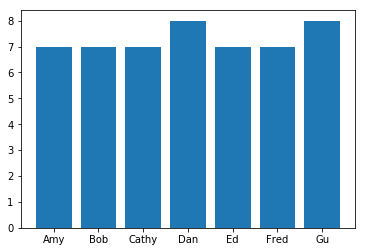

--------------------------------------------------
Assigments
Symbols: '-': not working, '*': working
  worker Mon1 Tue2 Wed3 Thu4 Fri5 Sat6 Sun7 Mon8 Tue9 Wed10 Thu11 Fri12 Sat13 Sun14
0    Amy    -    -    *    -    *    -    *    -    -     -     *     *     *     *
1    Bob    *    *    -    -    *    *    -    *    -     -     *     -     *     -
2  Cathy    -    -    -    *    *    -    *    -    *     *     -     *     *     -
3    Dan    -    *    *    -    -    *    -    -    -     *     *     *     *     *
4     Ed    *    -    -    *    *    -    *    -    *     -     *     -     *     -
5   Fred    *    -    *    -    -    *    -    *    -     -     -     *     *     *
6     Gu    -    -    *    -    *    *    *    -    -     *     -     *     *     *


In [ ]:
# 打印总松弛变量和每个工人工作的班次数
# 这个优化问题的关键绩效指标是满足需求所需的额外工人数量
# 以及每个雇佣工人正在工作的班次数。
solution = {}
shifts_sol = {}
solution['需要的总松弛变量'] = str(totSlack.X)
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in availability:
    if x[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]


print(pd.DataFrame.from_records(list(solution.items()), columns=['KPI', '值']))
print('-'*50)

for w in workers:
    shifts_sol[w]=totShifts[w].X
    assignments_all[w]=assignments.get(w, [])

print('班次')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['工人', '班次数']))
    
y_pos = np.arange(len(shifts_sol.keys())) 
plt.bar(y_pos,shifts_sol.values() , align='center')
plt.xticks(y_pos, shifts_sol.keys())
plt.show()

print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')

print('分配')
print('符号: \'-\': 不工作, \'*\': 工作')
pd.set_option('display.width', 1000)
print(pd.DataFrame.from_records(list(gant.values()), columns=['工人']+shifts))

## 分析

在规划期内满足班次需求所需的额外工人总数是七名。

柱状图显示了每个雇佣工人在规划期内将要工作的班次数量。可以看出，有七名额外工人的情况下，雇佣工人的工作量相当平衡。

最后一个表格显示了在规划期内每个雇佣工人在哪一天工作。

## 结论

在这个Jupyter Notebook中，我们讨论了服务行业常见的人力资源调度优化问题。
考虑一个服务型企业，它为未来两周制定人力资源计划。每个工作日只有一个班次。每个工作日的班次可能有不同的工人需求。该服务企业可以从中介机构雇佣额外工人以满足班次需求。该服务企业希望最小化需要雇佣的额外工人数量，作为次要目标，它希望平衡雇佣工人的工作量。

该问题被构建为一个多目标混合整数规划（MIP）模型，使用Gurobi Python API实现并使用Gurobi优化器求解。

详细解释了处理多目标函数问题的分层方法。


版权所有 © 2020 Gurobi Optimization, LLC